# Discrete Portfolio Numerical Optimization Using MGF Objective Functions

In this notebook, I use numpy to implement a gradient descent algorithm on a constrained optimization problem. I seek to minimizethe Moment Generating Function evaluated at $t=1$ of a portfolio composed of multiple independent random variables with defined probability mass functions.  
$$
\min_{\vec{a}} \ln (M_Z (1)) \\ \text{subject to} \\ \\ E[Z] \geq \mu_{\text{min}}
\\
\sum_{k=1}^{N} a_k = 1 \\ \sum_{k=1}^{N} |a_k| = 1
$$

$Z$ represents the portfolio (a random variable). Using the definition of the moment generating function of a discrete random variable, the optimization problem becomes the following equation.
$$
\min_{\vec{a}} \sum_{k=1}^{N} \ln (M_{X_k}(a_k)) \\ \text{subject to} \\ \\ E[Z] \geq \mu_{\text{min}}
\\ \sum_{k=1}^{N} a_k = 1 \\ \sum_{k=1}^{N} |a_k| = 1
$$

Where $X_k$ are the independent assets composing the portfolio and $a_k$ are the percentages of the portfolio allocated to each asset. The optimization problem seeks the allocation of assets that maximizes the MGF of the portfolio evaluated at $t=1$ given a minimum expected return $\mu_{\text{min}}$.

## Intuition
For a non-negative random variable $X$, the following bound holds:
$$
E[X^m] \leq (\frac{m}{et})^m M_X (t) \quad m > 0, \ t \geq 0
$$

By finding the portfolio that minimizes $M_Z(1)$ we are finding the portfolio that minimizes the upper bound of all moments of the portfolio's return. By utilizing the inequality constraint $E[Z] \geq \mu_{\text{min}}$ we should find the portfolio with the smallest moments given a minimum expected return. Since equities are often used to hedge against inflation, I will set $\mu_{\text{min}} > 1$ to simulate inflation. Also, $\mu_{\text{min}} > 1$ will force out negative returning portfolios with small moments out of the solution space.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

#Risky Call Option
x1 = np.array([0.0, 0.5, 1.6, 2.0])
px1 = np.array([0.6, 0.3, 0.05, 0.05])

#Uniform Asset
x2 = np.array([0.0, 0.3, 1.5, 2.5])
px2 = np.array([0.25, 0.25, 0.25, 0.25])

#Biased Coin Flip Asset
x3 = np.array([0.0, 0.5, 1.5, 2.1])
px3 = np.array([0.5, 0.0, 0.0, 0.5])

x = [x1, x2, x3]
px = [px1, px2, px3]

In [2]:
#precomputations
ex = [] #exponentiated x
E = [] #expected values of each distr
for i in range(len(x)):
    ex.append(np.exp(x[i]))
    E.append(np.dot(x[i], px[i]))
    
print(E)

[0.33, 1.075, 1.05]


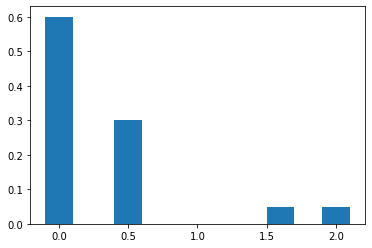

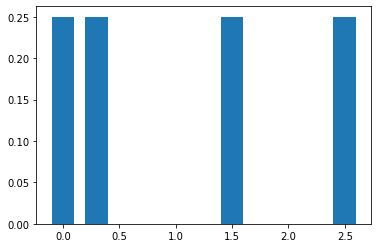

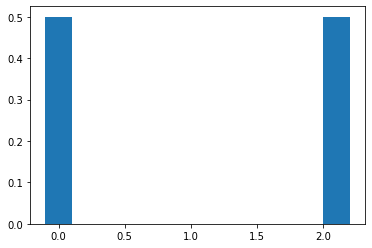

In [3]:
#Display probability distributions
for i in range(len(ex)):
    plt.bar(x[i], px[i], width=0.2)
    plt.show()

## Gradient Calculations

To convert the constrained problem to an unconstrained one, I define lagrangian.
$$
L(\vec{a}, \lambda_1, \lambda_2, \theta) = \sum_{k=1}^{N} \ln (M_{X_k}(a_k)) + \lambda_1 (\sum_{k=1}^{N} a_k - 1) + \lambda_2 (\sum_{k=1}^{N} |a_k| - 1) + \theta (E[Z] - \mu_{\text{min}} - s^2)
$$

The problem with the optmizing the lagrangian directly is that the solutions lie on saddle points; therefore, I modify the optimization problem to minimize the magnitude of the gradient of the lagrangian.

$$
h(\vec{a}, \lambda_1, \lambda_2, \theta, s) = \frac{1}{2}[ \sum_{i=1}^{N} (\frac{\partial L}{\partial a_i})^2 + (\frac{\partial L}{\partial \lambda_1})^2 + (\frac{\partial L}{\partial \lambda_2})^2 + (\frac{\partial L}{\partial \theta})^2]
$$

Where:
$$
\frac{\partial L}{\partial a_k} = \frac{\sum_{j=1}^{M} x_j e^{a_k x_j} p_{X_k} (x_j)}{\sum_{j=1}^{M} e^{a_k x_j} p_{X_k} (x_j)} + \lambda_1 + \text{sign}(a_k) \lambda_2 + E[X_k]\theta 
$$
$$
\frac{\partial L}{\partial \lambda_1} = \sum_{i=1}^{N} a_i - 1
$$

$$
\frac{\partial L}{\partial \lambda_2} = \sum_{i=1}^{N} |a_i| - 1
$$

$$
\frac{\partial L}{\partial \theta} = E[Z] - \mu_{\text{min}} - s^2
$$

Thus the gradient of our cost function $h$ become:

$$
\frac{\partial h}{\partial a_k} = \frac{\partial L}{\partial a_k}\frac{\partial^2 L}{\partial a_k^2} + (\sum_{i=1}^{N} a_i - 1) + \text{sign}(a_k)(\sum_{i=1}^{N} |a_i| - 1) + (\frac{\partial L}{\partial \theta})E[X_k]
$$

$$
\frac{\partial h}{\partial \lambda_1} = \sum_{i=1}^{N} \frac{\partial L}{\partial a_i}
$$

$$
\frac{\partial h}{\partial \lambda_2} = \sum_{i=1}^{N} \text{sign}(a_i) \frac{\partial L}{\partial a_i}
$$

$$
\frac{\partial h}{\partial \theta} = \sum_{i=1}^{N}( \frac{\partial L}{\partial a_i} E[X_i])
$$


In [4]:
#we need to minimize the square magnitude of lagrange... due to saddle points in original equation
#h(x, lag)  = 1/2 * magnitude of grad(L)

def h_gradient(port_var, constraints, mu=1.075): 
    gradient_var = []
    gradient_constraint = []
    h_grad1 = 0.0
    h_grad2 = 0.0
    h_ineq_grad = 0.0
    h_slack_grad = 0.0
    sum_vars = np.sum(port_var)
    abs_sum_vars = np.sum(np.abs(port_var))
    obj = 0.0
    
    slack_theta = np.dot(port_var, E) - mu
    if slack_theta >= 0:
        slack_theta = np.sqrt(slack_theta)
    else:
        slack_theta = 0.0
        
    dl_dtheta = np.dot(port_var, E) - mu - (slack_theta**2) #dl_dtheta only changes the current portfolio EV is too low.
    #dl_ds = -2*slack_theta*constraints[2]
    
    for i in range(len(port_var)):
        x_i = x[i]
        ex_i = ex[i]
        px_i = px[i]
        a_i = port_var[i]
        E_i = E[i]
        
        ex_scaled = np.power(ex_i, a_i)
        term1 = x_i * ex_scaled
        term2 = x_i * term1
        f_x = np.dot(term1, px_i)
        g_x = np.dot(ex_scaled, px_i)
        fp_x = np.dot(term2, px_i)
        obj += np.log(g_x)
        #gp_x = f_x 
        
        
        dl_di = (f_x/g_x) + constraints[0] + np.sign(a_i)*constraints[1] + E_i*constraints[2]
        #constraints[0 and 1] are the lagrange equality constraints
        #constraints[2] is the inequality constraint
        
        d2l_di2 = (fp_x*g_x - f_x*f_x)/(g_x*g_x)
        
        
        grad = (dl_di*d2l_di2) + (sum_vars - 1) + np.sign(a_i)*(abs_sum_vars - 1) + (dl_dtheta*E_i)
        
        h_grad1 += dl_di
        h_grad2 += np.sign(a_i)*dl_di
        h_ineq_grad += dl_di*E_i
        gradient_var.append(grad)
    
    #Now calculate gradient for lagrange variable
    #h_ineq_grad -= 2 * dl_ds * slack_theta
    #h_slack_grad = -2 * ((dl_dtheta*slack_theta) + (dl_ds)*constraints[2])
    gradient_constraint.append(h_grad1)
    gradient_constraint.append(h_grad2)
    gradient_constraint.append(h_ineq_grad)
    #gradient_constraint.append(h_slack_grad)
    
    
    return gradient_var, gradient_constraint, obj, slack_theta

In [5]:
def objective(port_var):
    obj = 0.0
    for i in range(len(port_var)):
        ex_i = ex[i]
        px_i = px[i]
        a_i = port_var[i]
        
        ex_scaled = np.power(ex_i, a_i)
        g_x = np.dot(ex_scaled, px_i)
        obj += np.log(g_x)
        
    return obj

def h_gradient_descent(port_var, constr_var, steps=100, lr=1e-3, mu=1.0, tol=1e-5): 
    #We want to minimize the norm of the gradient
    #mu is the minimum expected value of the portfolio
    #I haven't implemented tolerance yet
    
    grad_history = []
    constr_grad_history = []
    obj_history = []
    port_var_history = []
    constr_history = []
    slack_history = []
    var_np = np.array(port_var)
    constr_np = np.array(constr_var)
    
    for _ in range(steps):
        grad, grad_constr, obj, slack = h_gradient(var_np, constr_np, mu=mu)
        var_np -= lr*np.array(grad)
        constr_np -= lr*np.array(grad_constr)
        
        port_var_history.append(var_np.copy())
        constr_history.append(constr_np.copy())
        grad_history.append(grad)
        constr_grad_history.append(grad_constr)
        obj_history.append(obj)
        slack_history.append(slack)
        
        old_grad = grad
    
    return port_var_history, grad_history, constr_history, constr_grad_history, obj_history, slack_history, var_np



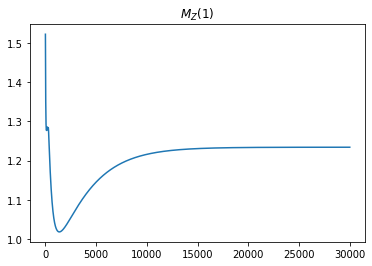

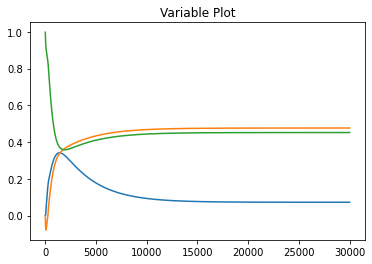

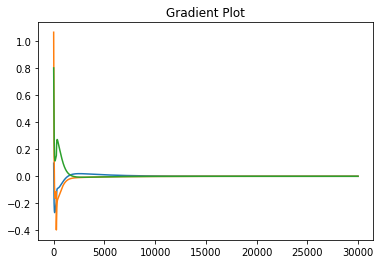

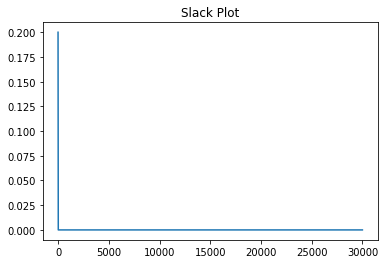

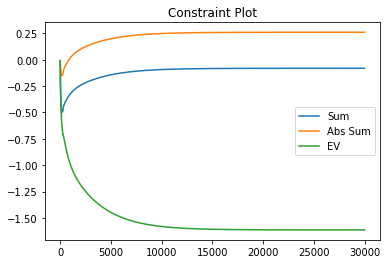

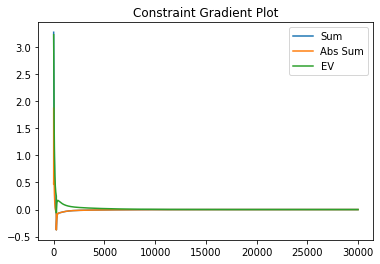

Optimal Portfolio:  [0.07211819 0.47621522 0.45167186]
Portfolio Sum Sanity Check:  1.0000052639366526
Normalized Portfolio:  [0.07211781 0.47621271 0.45166948]
Portfolio $M_Z(1)$:  1.2339487746600528
Portfolio $E[Z]$:  1.0099804964206984
Constraints:  [-0.08065546  0.26102506 -1.61340837]
Constraint Gradients:  [-1.7529578401065393e-06, -1.7529578401065393e-06, 4.7244910905508415e-06]


In [6]:
variables = [0.0, 0.0, 1.0]
constraints = [0.0, 0.0, 0.0]
var_history, grad_history, c_history, cgrad_history, obj_history, s_history, opt_var = h_gradient_descent(variables, 
                                                                                                          constraints, 
                                                                                                          lr=3e-3, 
                                                                                                          steps=30000, 
                                                                                                          mu=1.01)


plt.plot(obj_history)
plt.title("$M_Z(1)$")
plt.show()

plt.plot(var_history)
plt.title("Variable Plot")
plt.show()
plt.plot(grad_history)
plt.title("Gradient Plot")
plt.show()
plt.plot(s_history)
plt.title("Slack Plot")
plt.show()

plt.plot(c_history)
plt.title("Constraint Plot")
plt.legend(["Sum", "Abs Sum", "EV", "slack"])
plt.show()
plt.plot(cgrad_history)
plt.title("Constraint Gradient Plot")
plt.legend(["Sum", "Abs Sum", "EV", "slack"])
plt.show()
print("Optimal Portfolio: ", opt_var)
print("Portfolio Sum Sanity Check: ", np.sum(opt_var))
opt_var = opt_var/np.sum(opt_var)
print("Normalized Portfolio: ", opt_var)
print("Portfolio $M_Z(1)$: ", objective(opt_var))
print("Portfolio $E[Z]$: ", np.dot(opt_var, E))
print("Constraints: ", c_history[-1])
print("Constraint Gradients: ", cgrad_history[-1])

### Not a single convolution was calculated!!!!!!!!

In [7]:
#Line Search Sanity Check

a1 = 0.0
a2 = 1.0
res = 1000
objective_func = np.zeros((res, res))
a_x = []
for i in range(res):
    a1 = (i/(res-1))
    for j in range(res):
        a2 = (j/(res-1))
        if 1 - a1 - a2 < 0:
            break
        objective_func[i][j] = objective([a1, a2, 1-a1-a2])


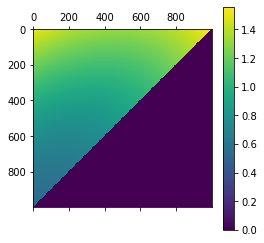

1.5588833892256737
[0.0, 1.0, 0.0]


In [8]:
plt.matshow(objective_func, cmap="viridis")
plt.colorbar()
plt.show()

obj_max = np.max(objective_func)
obj_argmax = np.unravel_index(np.argmax(objective_func, axis=None), 
                              objective_func.shape)

a1 = obj_argmax[0]/(res-1)
a2 = obj_argmax[1]/(res-1)
a3 = 1 - a1- a2
print(obj_max)
print([a1, a2, a3])